In [1]:
from __future__ import division  # Not needed for Python 3.x
import matplotlib.pyplot as plt
import numpy as np
from numpy import log
from scipy.optimize import fminbound
from scipy import interp
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# Defining Parameters
alpha = 0.65
beta = 0.95

# Defining out grid
grid_max = 2
grid_size = 150
grid = np.linspace(1e-6, grid_max, grid_size)

In [3]:
# Exact solution (for comparison)
ab = alpha * beta
c1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - beta)
c2 = alpha / (1 - ab)

def v_star(k):
    return c1 + c2 * log(k)

In [4]:
def bellman_operator(w):
    """
    The approximate Bellman operator, which computes and returns the updated
    value function Tw on the grid points.

        * w is a flat NumPy array with len(w) = len(grid)

    The vector w represents the value of the input function on the grid
    points.
    """
    # For a set of w=v(a), link the points such that we get a function w(a)
    Aw = lambda x: interp(x, grid, w)
    
    # Generate our next guess:
    Tw = np.empty(grid_size)                                         # Create space for our new guess, w'
    for i, k in enumerate(grid):                                     # for each index and value of k in out grid: 
        objective = lambda c: - log(c) - beta * Aw(k**alpha - c)     # define the objective function (in one line)
        c_star = fminbound(objective, 1e-6, k**alpha)                # find the optimal c* that max. u(c) + beta w(a'(c))
        Tw[i] = - objective(c_star)                                  # store the values for our v(c*) => w'

    return Tw                                                        # Return those values as our new w'

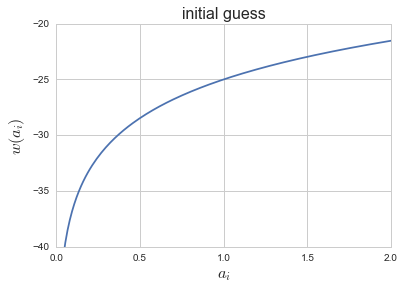

In [28]:
# initial condition
w0 = 5 * log(grid) - 25

plt.ylim(-40, -20)
plt.plot(grid, w0)
plt.ylabel('$w(a_i)$', fontsize=16)
plt.xlabel('$a_i$', fontsize=16)
plt.title('initial guess', fontsize=16)
plt.show()

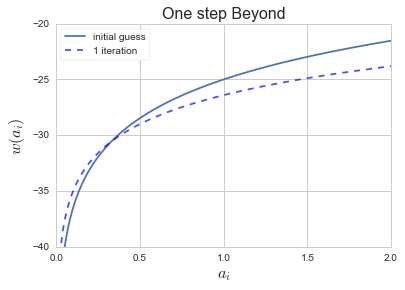

In [6]:
# Roll the bellman operator once
w1 = bellman_operator(w0)

plt.ylim(-40, -20)
plt.plot(grid, w0, label='initial guess')
plt.plot(grid, w1, c='blue', alpha=0.7, ls='--', label='1 iteration')
plt.ylabel('$w(a_i)$', fontsize=16)
plt.xlabel('$a_i$', fontsize=16)
plt.title('One step Beyond', fontsize=16)
plt.legend(loc='best', frameon=True)
plt.show()

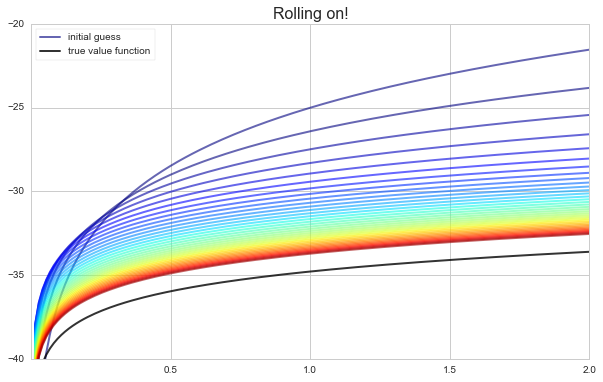

In [7]:
# Now solve!
n = 35

plt.figure(figsize=(10,6))
plt.ylim(-40, -20)
plt.xlim(np.min(grid), np.max(grid))
plt.plot(grid, w0, color=plt.cm.jet(0), lw=2, alpha=0.6, label='initial guess')

w = w0
for i in range(n):
    w = bellman_operator(w)
    plt.plot(grid, w, color=plt.cm.jet(i / n), lw=2, alpha=0.6)
plt.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label='true value function')
plt.legend(loc='upper left', frameon='True')

plt.title('Rolling on!', fontsize=16)

plt.show()

In [8]:
# Keep on going until convergence

w = w0
tol = 1e-6
distance = np.abs(np.max(w0 - bellman_operator(w0)))
iterations = 0
while distance > tol:
    w_next = bellman_operator(w)
    distance = np.abs(np.max(w - w_next))
    w = w_next
    iterations += 1
    if iterations % 50 == 0:
        print ' after {} iterations, distance is {}'.format(iterations, distance)
print 'Done'

 after 50 iterations, distance is 0.339326498991
 after 100 iterations, distance is 0.0243243552158
 after 150 iterations, distance is 0.00173746679604
 after 200 iterations, distance is 0.000124172042035
 after 250 iterations, distance is 8.87931190618e-06
Done


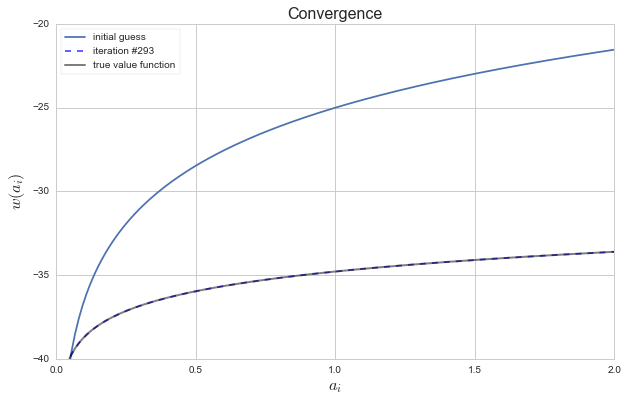

In [9]:
# plot the result
plt.figure(figsize=(10,6))
plt.ylim(-40, -20)
plt.plot(grid, w0, label='initial guess')
plt.plot(grid, w, c='blue', alpha=0.7, ls='--', label='iteration #{}'.format(iterations))
plt.ylabel('$w(a_i)$', fontsize=16)
plt.xlabel('$a_i$', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.5, label='true value function')
plt.legend(loc='best', frameon=True)
plt.show()

In [10]:
def bellman_operator_plus(w, return_policy=False, grid=np.linspace(1e-6, 2, 150), u=lambda x: log(x)):
    """
    The approximate Bellman operator, which computes and returns the updated
    value function Tw on the grid points.
    Inputs:
        * w is a flat NumPy array with len(w) = len(grid)
        * return_policy is a boolean, if true returns w (value) and c (optimal policy)
        * grid is a NumPy array with one-dimensional vector of state points
        * u is a function with a single numerical argument: instantaneous utility function

    Returns:
        * w  - and if return_policy==True, a tuple (w,c)
    """
    # For a set of w=v(a), link the points such that we get a function w(a)
    Aw = lambda x: interp(x, grid, w)
    
    # Generate our next guess:
    Tw = np.empty(grid_size)                                         # Create space for our new guess, w'
    policy = np.empty(grid_size)
    for i, k in enumerate(grid):                                     # for each index and value of k in out grid: 
        objective = lambda c: - u(c) - beta * Aw(k**alpha - c)     # define the objective function (in one line)
        c_star = fminbound(objective, 1e-6, k**alpha)                # find the optimal c* that max. u(c) + beta w(a'(c))
        Tw[i] = - objective(c_star)                                  # store the values for our v(c*) => w'
        policy[i] = c_star
    # Return time
    if return_policy==False:
        return Tw                                                    # Return those values as our new w'
    else:
        return (Tw,policy)

In [11]:
w = w0
tol = 1e-6
distance = np.abs(np.max(w0 - bellman_operator(w0)))
iterations = 0
while distance > tol:
    bellman = bellman_operator_plus(w, return_policy=True)
    w_next = bellman[0]
    policy = bellman[1]
    distance = np.abs(np.max(w - w_next))
    w = w_next
    iterations += 1
    if iterations % 50 == 0:
        print ' after {} iterations, distance is {}'.format(iterations, distance)
print 'Done'

 after 50 iterations, distance is 0.339326498991
 after 100 iterations, distance is 0.0243243552158
 after 150 iterations, distance is 0.00173746679604
 after 200 iterations, distance is 0.000124172042035
 after 250 iterations, distance is 8.87931190618e-06
Done


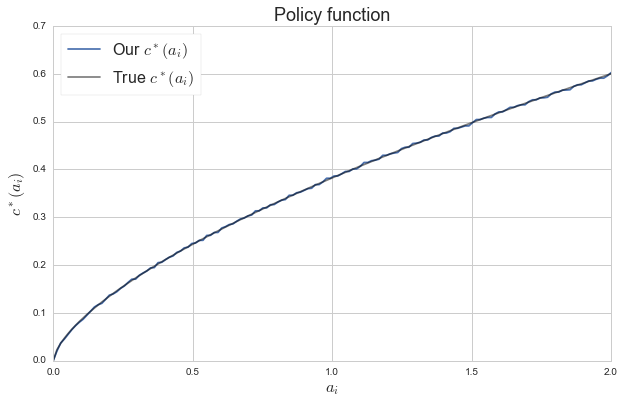

In [12]:
true_c = (1 - alpha * beta) * grid**alpha

plt.figure(figsize=(10,6))
plt.plot(grid,policy, label='Our $c^*(a_i)$')
plt.plot(grid,true_c, color='black', alpha=0.5, label='True $c^*(a_i)$')
plt.title('Policy function', fontsize=18)
plt.xlabel('$a_i$', fontsize=16)
plt.ylabel('$c^*(a_i)$', fontsize=16)
plt.legend(loc='best',fontsize=16, frameon=True)
plt.show()

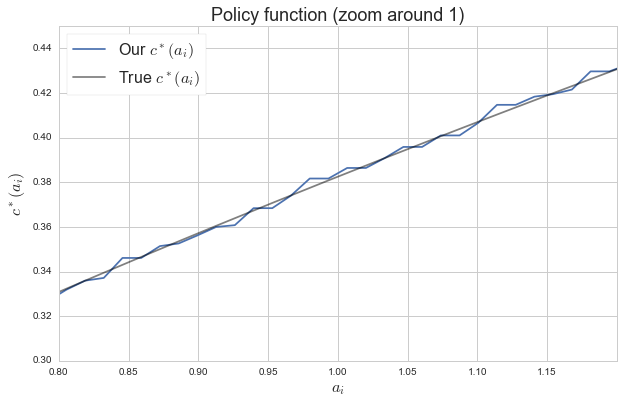

In [13]:
# Zoom in
plt.figure(figsize=(10,6))
plt.plot(grid,policy, label='Our $c^*(a_i)$')
plt.plot(grid,true_c, color='black', alpha=0.5, label='True $c^*(a_i)$')
plt.title('Policy function (zoom around 1)', fontsize=18)
plt.xlabel('$a_i$', fontsize=16)
plt.ylabel('$c^*(a_i)$', fontsize=16)
plt.xlim(0.8,1.2)
plt.ylim(0.3,0.45)
plt.legend(loc='best',fontsize=16, frameon=True)
plt.show()

In [39]:
sigma=0.7
crra_u = lambda x: (x**(1-sigma) - 1)/(1-sigma)

w = w0
tol = 1e-5
distance = np.abs(np.max(w0 - bellman_operator(w0)))
iterations = 0
while distance > tol:
    bellman = bellman_operator_plus(w, return_policy=True, u =crra_u)
    w_next = bellman[0]
    policy07 = bellman[1]
    distance = np.abs(np.max(w - w_next))
    w = w_next
    iterations += 1
    if iterations % 50 == 0:
        print ' after {} iterations, distance is {}'.format(iterations, distance)
print 'Done'

 after 50 iterations, distance is 0.00439368792803
 after 100 iterations, distance is 0.00033806187249
 after 150 iterations, distance is 2.60012002613e-05
Done


In [37]:
sigma=1.2
crra_u = lambda x: (x**(1-sigma) - 1)/(1-sigma)

w12 = w0
tol = 1e-6
distance = np.abs(np.max(w0 - bellman_operator(w0)))
iterations = 0
while distance > tol:
    bellman = bellman_operator_plus(w12, return_policy=True, u =crra_u)
    w_next = bellman[0]
    policy12 = bellman[1]
    distance = np.abs(np.max(w12 - w_next))
    w12 = w_next
    iterations += 1
    if iterations % 50 == 0:
        print ' after {} iterations, distance is {}'.format(iterations, distance)
print 'Done'

 after 50 iterations, distance is 1.67353158258
 after 100 iterations, distance is 0.107838138009
 after 150 iterations, distance is 0.00843366478557
 after 200 iterations, distance is 0.000659492378531
 after 250 iterations, distance is 5.15707361615e-05
 after 300 iterations, distance is 4.03273480742e-06
Done


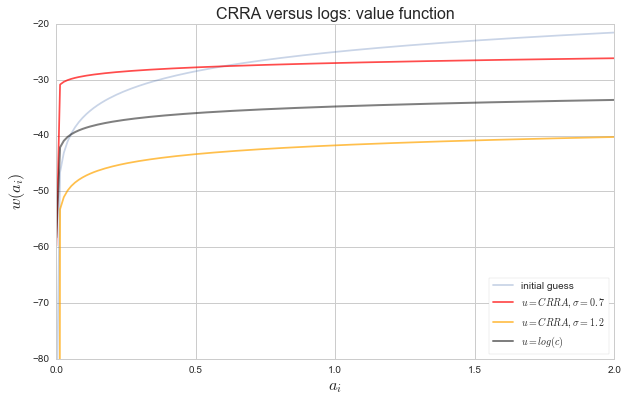

In [36]:
# plot the result
plt.figure(figsize=(10,6))
plt.ylim(-80, -20)
plt.plot(grid, w0, label='initial guess', alpha=0.3)
plt.plot(grid, w, c='red', alpha=0.7, label='$u = CRRA, \sigma=0.7$')
plt.plot(grid, w12, c='orange', alpha=0.7, label='$u = CRRA, \sigma=1.2$')
plt.ylabel('$w(a_i)$', fontsize=16)
plt.xlabel('$a_i$', fontsize=16)
plt.title('CRRA versus logs: value function', fontsize=16)
plt.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.5, label='$u = log(c)$')
plt.legend(loc='best', frameon=True)
plt.show()

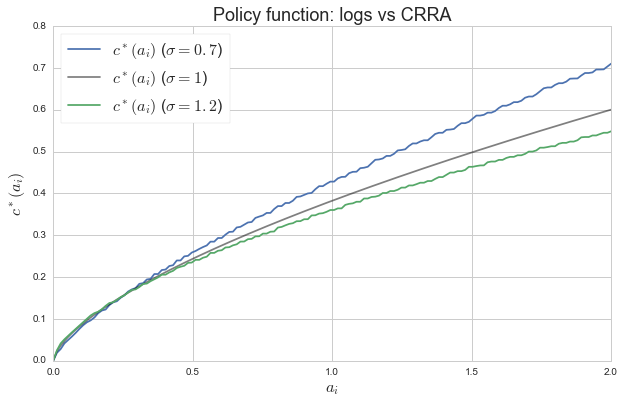

In [40]:
log_c = (1 - alpha * beta) * grid**alpha

plt.figure(figsize=(10,6))
plt.plot(grid,policy07, label='$c^*(a_i)$ ($\sigma=0.7$)')
plt.plot(grid,log_c, color='black', alpha=0.5, label='$c^*(a_i)$ ($\sigma=1$)')
plt.plot(grid,policy12, label='$c^*(a_i)$ ($\sigma=1.2$)')
plt.title('Policy function: logs vs CRRA', fontsize=18)
plt.xlabel('$a_i$', fontsize=16)
plt.ylabel('$c^*(a_i)$', fontsize=16)
plt.legend(loc='best',fontsize=16, frameon=True)
plt.show()

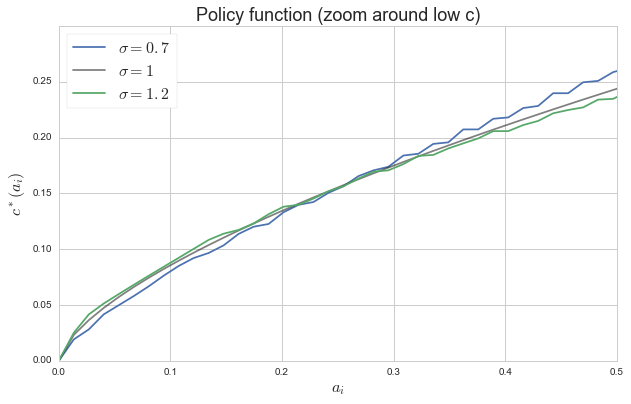

In [42]:
# Zoom in
plt.figure(figsize=(10,6))

plt.plot(grid,policy07, label='$\sigma=0.7$')
plt.plot(grid,log_c, color='black', alpha=0.5, label='$\sigma=1$')
plt.plot(grid,policy12, label='$\sigma=1.2$')
plt.title('Policy function (zoom around low c)', fontsize=18)
plt.xlabel('$a_i$', fontsize=16)
plt.ylabel('$c^*(a_i)$', fontsize=16)
plt.xlim(0,0.5)
plt.ylim(0.0,0.3)
plt.legend(loc='best',fontsize=16, frameon=True)

plt.show()